<a href="https://colab.research.google.com/github/haakonms/annminiproject/blob/master/miniproject1_2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [0]:
student1 = "Håkon Melgård Sveen"
student2 = "Mimmi Sofie Gjems"


- 6 and 7: Since task 7 says that we should use sigmoidal instead of relu activation, does that mean that we should use relu activation throughout all layers of our CNN in task 6?


## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [0]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [0]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation loss")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation accuracy")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


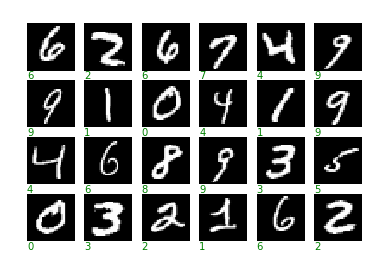

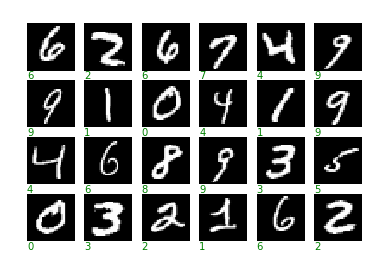

In [0]:
plot_some_samples(x_train, y_train, select_from = list(range(0, 48)))

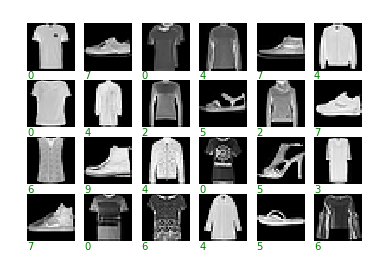

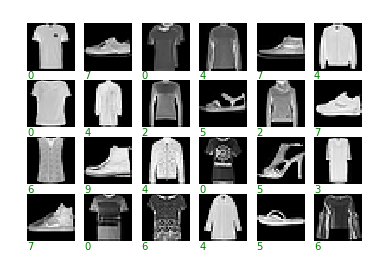

In [0]:
plot_some_samples(x_fashion_train, y_fashion_train)

Answer to question 2: The green indices indicates the correct classification of the picture.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [0]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Solution for the MNIST dataset:

In [0]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Dense(10, activation="softmax"))

In [0]:
#Answer on 2,3 and 4. 
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])

5 and 6) Add minibatch and fit for as many epochs as needed:

7)

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.8664 - acc: 0.7908 - val_loss: 0.5165 - val_acc: 0.8714
Epoch 2/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.4775 - acc: 0.8742 - val_loss: 0.4134 - val_acc: 0.8892
Epoch 3/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.4115 - acc: 0.8875 - val_loss: 0.3731 - val_acc: 0.8981
Epoch 4/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.3798 - acc: 0.8938 - val_loss: 0.3511 - val_acc: 0.9032
Epoch 5/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.3605 - acc: 0.8991 - val_loss: 0.3360 - val_acc: 0.9065
Epoch 6/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.3471 - acc: 0.9021 - val_loss: 0.3257 - val_acc: 0.9098
Epoch 7/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.3372 - acc: 0.9052 - val_loss: 0.3177 - 

We can see no more effect on the validation loss after the 85th epoch.

In [0]:
plot_history(history, "100 epochs")

Task 8) 

In [0]:
#Create a prediction from the model.
prob = model.predict(x_test)
pred = np.zeros_like(prob)
pred[np.arange(len(prob)), prob.argmax(1)] = 1
pred[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
#This method returns the wrongly classified y-values from our model and the indices these values has in both x_test and y_test
def find_error_indices(y_predicted, y_test):
  wrongly_classified = []
  error_indices = []
  for i in range(len(y_test)):
    # Checks for each prediction if it is correct
    if y_predicted[i].argmax() != y_test[i].argmax():
      #Adds the wrong ones to a new list.
      wrongly_classified.append(y_predicted[i])
      error_indices.append(i)
  return wrongly_classified, error_indices
      
  
  
  

In [0]:
#Assigning the results from the function.
wrongly_classified, error_indices = find_error_indices(pred, y_test)

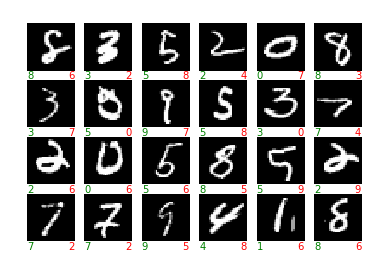

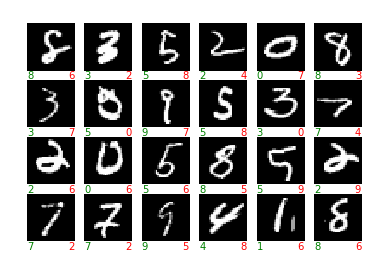

In [0]:
plot_some_samples(x_test[error_indices], y_test[error_indices], yhat = wrongly_classified)


The green indices are the correct classification, and the red indices are the wrong prediction from our model. We can see that many of these numbers are faded or indistinct, which make them harder to predict.

**For the Fashion Model, task 9:**

In [0]:
fashion_model = Sequential()
fashion_model.add(Dense(512, input_shape=(784,)))
fashion_model.add(Dense(10, activation="softmax"))
fashion_model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])

In [0]:
fashion_history = fashion_model.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))


In [0]:
plot_history(fashion_history, "Fashion MNIST with no hidden layers, hundred epochs")

Task 8, with the fashion dataset:

In [0]:
fashion_prob = model.predict(x_fashion_test)
fashion_pred = np.zeros_like(fashion_prob)
fashion_pred[np.arange(len(fashion_prob)), fashion_prob.argmax(1)] = 1

In [0]:
#Assigning the results from the function.
fashion_wrongly_classified, fashion_error_indices = find_error_indices(pred, y_fashion_test)

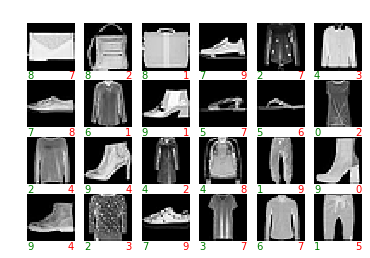

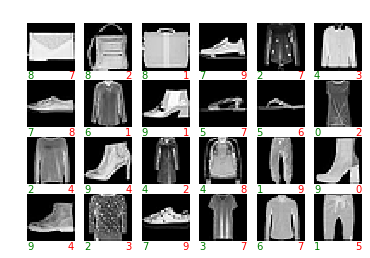

In [0]:
plot_some_samples(x_fashion_test[fashion_error_indices], y_fashion_test[fashion_error_indices], yhat = fashion_wrongly_classified)


No hidden layer only gave xx% validation accuracy, so this model has room for improvement, and it is hard to say what kind of features that were hard for the model here.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

1) 

In [0]:
one_layer_model = Sequential()
one_layer_model.add(Dense(512, input_shape=(784,)))
one_layer_model.add(Dense(128, activation="relu"))
one_layer_model.add(Dense(10, activation="relu"))
one_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


#### 2)

Fitting model for four different learning rates of stochastic gradient descent with 50 epochs on each.

Learning rate of 0.01:

In [0]:
sgd1 = SGD(lr=0.01)
one_layer_model.compile(loss="categorical_crossentropy", optimizer=sgd1, metrics = ["accuracy"])
print(keras.backend.eval(one_layer_model.optimizer.lr))


0.01


In [0]:
learning_rate1 = one_layer_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 36us/step - loss: 5.4812 - acc: 0.0914 - val_loss: 5.0480 - val_acc: 0.0952
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 4.4580 - acc: 0.1716 - val_loss: 3.4836 - val_acc: 0.2757
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 3.9183 - acc: 0.2206 - val_loss: 6.6042 - val_acc: 0.0892
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 6.4426 - acc: 0.0903 - val_loss: 6.4535 - val_acc: 0.0892
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 6.3704 - acc: 0.0903 - val_loss: 6.4151 - val_acc: 0.0892
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 6.3431 - acc: 0.0903 - val_loss: 6.3954 - val_acc: 0.0892
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 6.3276 - acc: 0.0904 - val_loss: 6.3831 - val_acc

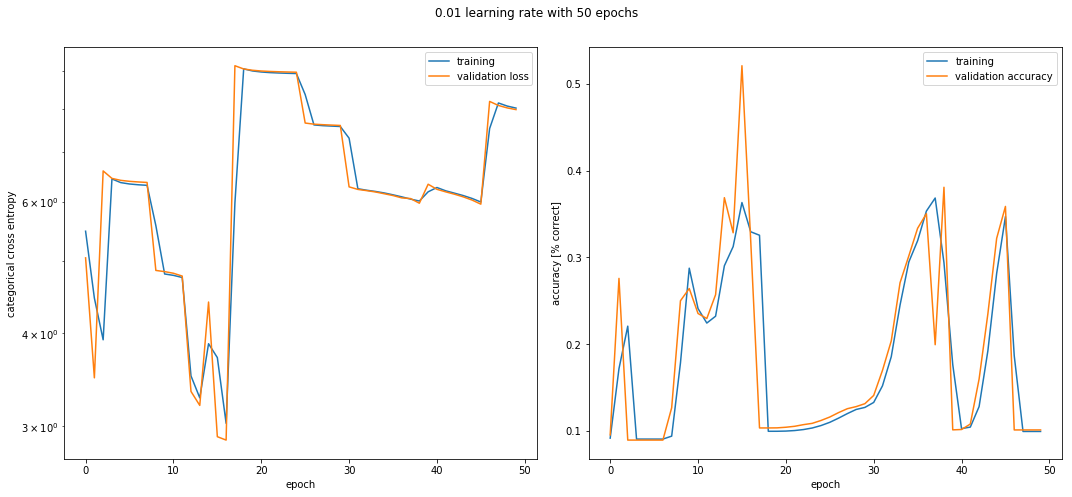

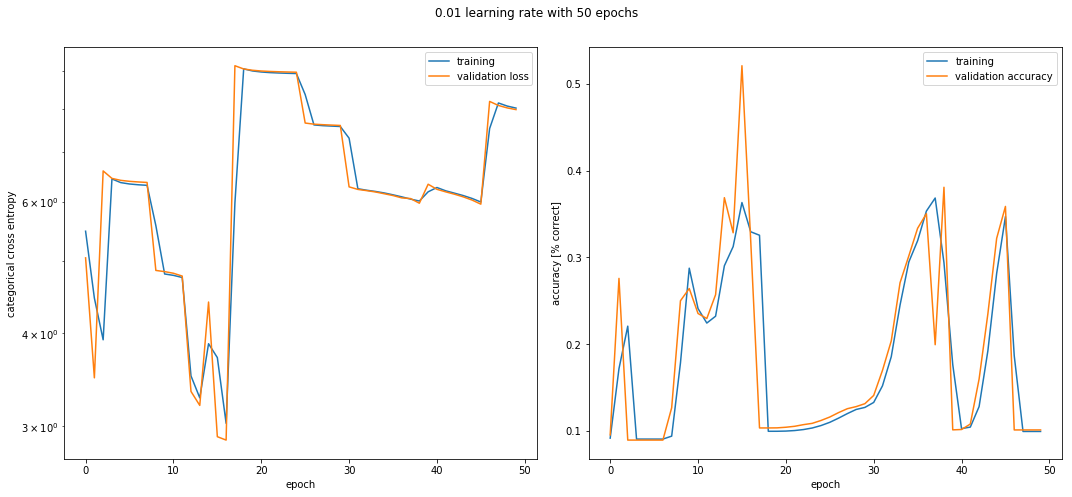

In [0]:
plot_history(learning_rate1, "0.01 learning rate with 50 epochs")

Learning rate of 0.1

In [0]:
#Helper function to reset the weigths for different optimizers and learning rate.
def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [0]:
reset_weights(one_layer_model)
sgd2 = SGD(lr=0.1)
one_layer_model.compile(loss="categorical_crossentropy", optimizer=sgd2, metrics = ["accuracy"])
print(keras.backend.eval(one_layer_model.optimizer.lr))

0.1


In [0]:
learning_rate2 = one_layer_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [0]:
plot_history(learning_rate2, "0.1 learning rate with 50 epochs")

**3)** Replacing SGD with adam optimizer.

In [0]:
reset_weights(one_layer_model)
one_layer_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
print(keras.backend.eval(one_layer_model.optimizer.lr))

0.001


In [0]:
adam_history = one_layer_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 2.7201 - acc: 0.6261 - val_loss: 2.7037 - val_acc: 0.4748
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.5752 - acc: 0.6683 - val_loss: 2.3961 - val_acc: 0.7919
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.4830 - acc: 0.6748 - val_loss: 3.0574 - val_acc: 0.2046
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.5952 - acc: 0.5431 - val_loss: 2.6355 - val_acc: 0.7204
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.3722 - acc: 0.7527 - val_loss: 2.1776 - val_acc: 0.7872
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.3436 - acc: 0.6891 - val_loss: 2.2503 - val_acc: 0.7770
Epoch 7/50
60000/60000 [==============================] - 2s 32us/step - loss: 2.3664 - acc: 0.7321 - val_loss: 2.2209 - val_acc

### 4)

In [0]:
reset_weights(one_layer_model)
sgd3 = SGD(lr=0.05)
one_layer_model.compile(loss="categorical_crossentropy", optimizer=sgd3, metrics = ["accuracy"])
print(keras.backend.eval(one_layer_model.optimizer.lr))

NameError: ignored

In [0]:
learning_rate3 = one_layer_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.6664 - acc: 0.2154 - val_loss: 1.5243 - val_acc: 0.4524
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 1.8730 - acc: 0.4355 - val_loss: 1.8562 - val_acc: 0.1537
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 2.1129 - acc: 0.4816 - val_loss: 4.7164 - val_acc: 0.0959
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 2.8745 - acc: 0.2675 - val_loss: 1.6260 - val_acc: 0.2313
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 1.3801 - acc: 0.5675 - val_loss: 6.9787 - val_acc: 0.0958
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 4.5133 - acc: 0.1004 - val_loss: 3.5965 - val_acc: 0.1306
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 3.5613 - acc: 0.1547 - val_loss: 3.4887 - val_acc

In [0]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

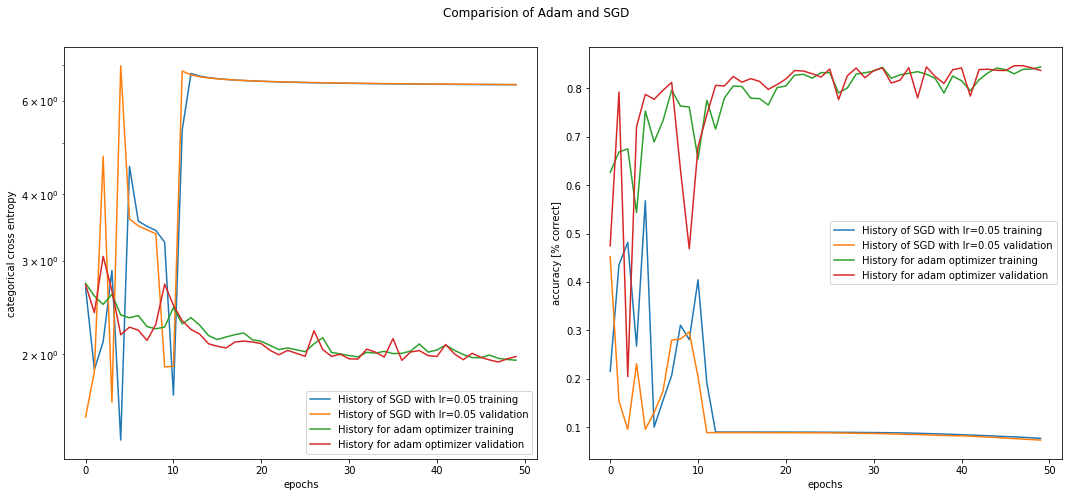

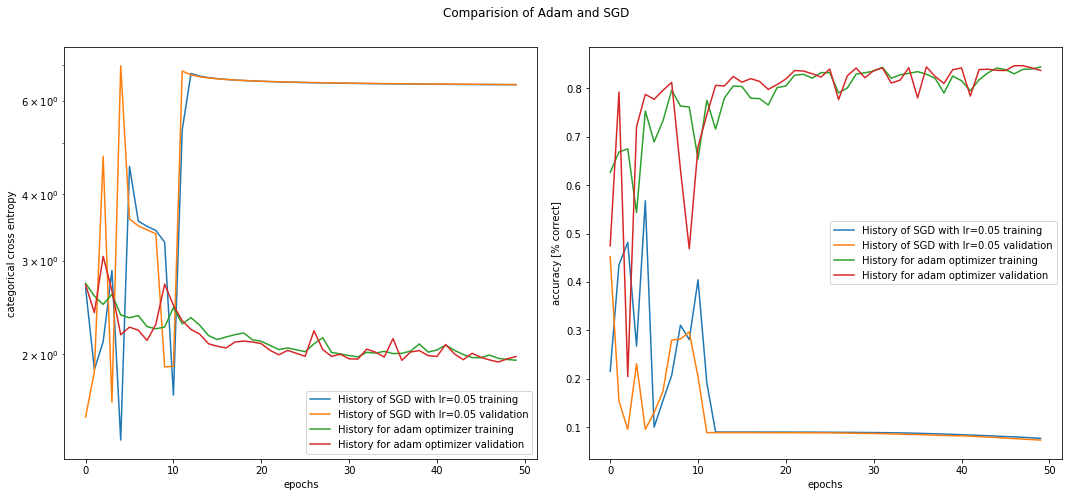

In [0]:
comparison_plot(learning_rate3, adam_history, "History of SGD with lr=0.05", "History for adam optimizer", "Comparision of Adam and SGD")

### 5)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) The small learning rate results in a low accuracy and that we do not really train our model as the loss has increased from the first epoch.

B) The high learning rate results in better accuracy sometimes, but makes the training extremely unstable.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: It seems like it started to overfit at the 47th or 48th epoch, which both have the highest validation accuracy.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Her må det skrivast.

### 6) 
Running the model on the fashion dataset with adam optimizer.

In [0]:
reset_weights(one_layer_model)
one_layer_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [0]:
fashion_one_layer_history = one_layer_model.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 3.9625 - acc: 0.5553 - val_loss: 3.7765 - val_acc: 0.6626
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 3.7340 - acc: 0.6477 - val_loss: 3.7749 - val_acc: 0.6510
Epoch 3/50
60000/60000 [==============================] - 2s 32us/step - loss: 3.8115 - acc: 0.6071 - val_loss: 3.7995 - val_acc: 0.6716
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 3.7670 - acc: 0.6160 - val_loss: 3.9192 - val_acc: 0.4260
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 3.7547 - acc: 0.6045 - val_loss: 3.9238 - val_acc: 0.5760
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 3.7985 - acc: 0.5816 - val_loss: 3.8061 - val_acc: 0.6008
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 3.7997 - acc: 0.6374 - val_loss: 3.7063 - val_acc

In [0]:
plot_history(fashion_one_layer_history, "adam optimizer on the fashion dataset.")

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

1)

First model with 512 hidden neurons:

In [0]:
hidden_neurons_model_512 = Sequential()
hidden_neurons_model_512.add(Dense(512, input_shape=(784,)))
hidden_neurons_model_512.add(Dense(512, activation="relu"))
hidden_neurons_model_512.add(Dense(10, activation="relu"))
hidden_neurons_model_512.summary()
hidden_neurons_model_512.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_512 = hidden_neurons_model_512.fit(x_train, y_train,
                    batch_size=128,
                    epochs=250,
                    verbose=1,
                    validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 5s 75us/step - loss: 1.2686 - acc: 0.6033 - val_loss: 0.9263 - val_acc: 0.6601
Epoch 2/250
60000/60000 [==============================] - 2s 32us/step - loss: 1.0224 - acc: 0.6698 - val_loss: 0.8495 - val_acc: 0.8144
Epoch 3/250
60000/60000 [==============================] - 2s 34us/step - loss: 0.9817 - acc: 0.6895 - val_loss: 0.8714 - val_acc: 0.8330
Epoch 4/250
60000/60000 [==============================] - 2s 35us/step - loss: 0.8207 - acc: 0.8025 - val_loss: 0.6904 - val_acc: 0.8416
Epoch 5/250
60000/60000 [==============================] - 2s 36us/step - loss: 0.7848 - acc: 0.8009 - val_loss: 0.7864 - val_acc: 0.8618
Epoch 6/250
60000/60000 [==============================] - 2s 36us/step - loss: 0.7363 - acc: 0.8242 - val_loss: 0.6407 - val_acc: 0.8855
Epoch 7/250
60000/60000 [==============================] - 2s 36us/step - 

First try I got the highest validation accuracy on the 197th epoch, and 96.01% accuracy.

Second model with 1000 hidden neurons

In [0]:
hidden_neurons_model_1000 = Sequential()
hidden_neurons_model_1000.add(Dense(512, input_shape=(784,)))
hidden_neurons_model_1000.add(Dense(1000, activation="relu"))
hidden_neurons_model_1000.add(Dense(10, activation="relu"))
hidden_neurons_model_1000.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
hidden_neurons_model_1000.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              513000    
_________________________________________________________________
dense_18 (Dense)             (None, 10)                10010     
Total params: 924,930
Trainable params: 924,930
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_1000 = hidden_neurons_model_1000.fit(x_train, y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 86us/step - loss: 1.1929 - acc: 0.7493 - val_loss: 0.6676 - val_acc: 0.8592
Epoch 2/200
60000/60000 [==============================] - 3s 42us/step - loss: 0.7438 - acc: 0.8565 - val_loss: 0.8008 - val_acc: 0.7832
Epoch 3/200
60000/60000 [==============================] - 3s 44us/step - loss: 0.7058 - acc: 0.8475 - val_loss: 0.5030 - val_acc: 0.9131
Epoch 4/200
60000/60000 [==============================] - 3s 45us/step - loss: 0.6281 - acc: 0.8756 - val_loss: 0.5526 - val_acc: 0.9169
Epoch 5/200
60000/60000 [==============================] - 3s 46us/step - loss: 0.6605 - acc: 0.8565 - val_loss: 0.5865 - val_acc: 0.8970
Epoch 6/200
60000/60000 [==============================] - 3s 45us/step - loss: 0.9346 - acc: 0.7118 - val_loss: 0.7524 - val_acc: 0.7099
Epoch 7/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.6269 - acc: 0.8583 - val_loss: 0.5369 - 

Third model with 200 hidden neurons:

In [0]:
hidden_neurons_model_200 = Sequential()
hidden_neurons_model_200.add(Dense(512, input_shape=(784,)))
hidden_neurons_model_200.add(Dense(200, activation="relu"))
hidden_neurons_model_200.add(Dense(10, activation="relu"))
hidden_neurons_model_200.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
hidden_neurons_model_200.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               102600    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2010      
Total params: 506,530
Trainable params: 506,530
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_200 = hidden_neurons_model_200.fit(x_train, y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test))

NameError: ignored

Fourth model with 64 hidden neurons:

In [0]:
hidden_neurons_model_64 = Sequential()
hidden_neurons_model_64.add(Dense(512, input_shape=(784,)))
hidden_neurons_model_64.add(Dense(64, activation="relu"))
hidden_neurons_model_64.add(Dense(10, activation="relu"))
hidden_neurons_model_64.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
hidden_neurons_model_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 435,402
Trainable params: 435,402
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_64 = hidden_neurons_model_64.fit(x_train, y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 6s 97us/step - loss: 1.4239 - acc: 0.7899 - val_loss: 0.6923 - val_acc: 0.8660
Epoch 2/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.9215 - acc: 0.8147 - val_loss: 0.9585 - val_acc: 0.6500
Epoch 3/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.7921 - acc: 0.8255 - val_loss: 0.5940 - val_acc: 0.8960
Epoch 4/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.8901 - acc: 0.8090 - val_loss: 0.7058 - val_acc: 0.8660
Epoch 5/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.9373 - acc: 0.7258 - val_loss: 0.7530 - val_acc: 0.8562
Epoch 6/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.8015 - acc: 0.8219 - val_loss: 3.5787 - val_acc: 0.1475
Epoch 7/200
60000/60000 [==============================] - 2s 40us/step - loss: 1.1872 - acc: 0.5922 - val_loss: 0.9080 - 

Fifth and last model with 10 hidden neurons:

In [0]:
hidden_neurons_model_10 = Sequential()
hidden_neurons_model_10.add(Dense(512, input_shape=(784,)))
hidden_neurons_model_10.add(Dense(10, activation="relu"))
hidden_neurons_model_10.add(Dense(10, activation="relu"))
hidden_neurons_model_10.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
hidden_neurons_model_10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
Total params: 407,160
Trainable params: 407,160
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_10 = hidden_neurons_model_10.fit(x_train, y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 35us/step - loss: 4.1982 - acc: 0.5674 - val_loss: 3.8241 - val_acc: 0.6454
Epoch 2/200
60000/60000 [==============================] - 2s 31us/step - loss: 3.6946 - acc: 0.6890 - val_loss: 3.8008 - val_acc: 0.6839
Epoch 3/200
60000/60000 [==============================] - 2s 31us/step - loss: 3.6422 - acc: 0.7068 - val_loss: 3.5417 - val_acc: 0.7343
Epoch 4/200
60000/60000 [==============================] - 2s 31us/step - loss: 3.5190 - acc: 0.7356 - val_loss: 3.5576 - val_acc: 0.7429
Epoch 5/200
60000/60000 [==============================] - 2s 31us/step - loss: 3.4805 - acc: 0.7394 - val_loss: 3.4893 - val_acc: 0.7373
Epoch 6/200
60000/60000 [==============================] - 2s 31us/step - loss: 3.5032 - acc: 0.7361 - val_loss: 3.8377 - val_acc: 0.6595
Epoch 7/200
60000/60000 [==============================] - 2s 32us/step - loss: 3.5558 - acc: 0.6965 - val_loss: 3.4774 - 

Statistics for the MNIST dataset with all models running 100 epochs, first try:
- 1000 hidden neurons: Best validation accuracy 96,54% on 172th epoch. (First try)
- 512 hidden neurons: Best validation accuracy on 197 th epoch first try, 96.16% on 144th epoch on the second try.
- 200 hidden neurons: Best validation accuracy 96.01% on 100th epoch. (first try) Second try 85,79% on second try. 96.16% on 187th epoch on third try.
- 64 hidden neurons: Best validation accuray 95.17% on 100th epoch. (first try) 95.65% at 187th epoch second try.
- 10 hidden neurons: Best validation accuracy 91.04% on 88th epoch (90.19% on 46th epoch)
   Second try 85.67 best on 196th epoch. Third try 85.54% on 188th epoch.

- Started overfitting around the 150th epoch on 512 hidden neurons.

In [0]:
def plot_result_vs_neurons(accuracies, neurons, title):
  fig, ax = plt.subplots(1, 1, figsize=(15,7))
  fig.suptitle(title)
  ax.bar(x = [1,2,3,4,5], height = accuracies, width =0.5, label = "Best accuracies for each model")
  ax.set_xticks([1,2,3,4,5])
  ax.set_xticklabels(neurons)
  ax.set_xlabel("Number of neurons in the hidden layer for each model")
  ax.set_ylabel("Accuracies in %")
  ax.set_ylim([80,100])
  return fig
  

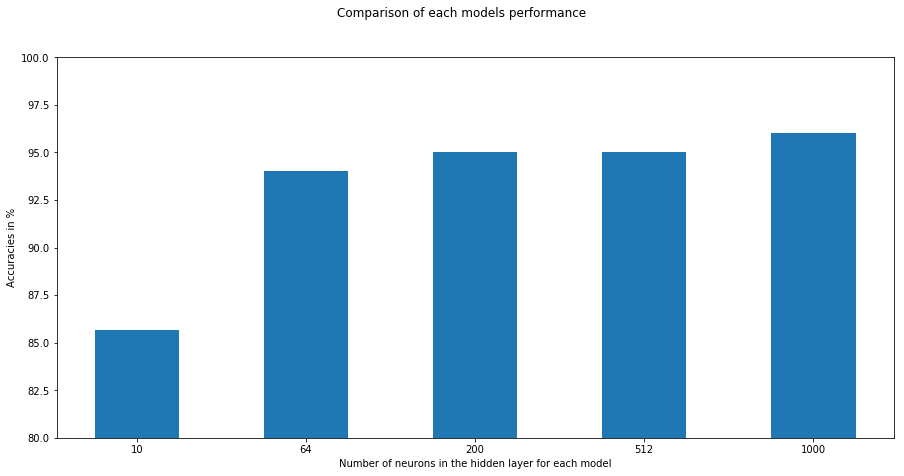

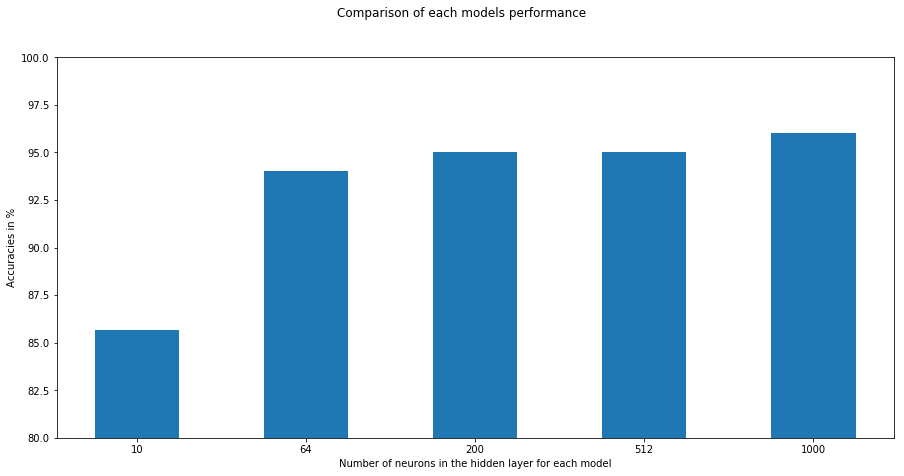

In [0]:

accuracies = [85.64, 94,95,95,96]
neurons = [10, 64, 200, 512, 1000]
plot_result_vs_neurons(accuracies, neurons, "Comparison of each models performance")

Answer to question 2: The theorem states that the width has to be exponentially large for a single hidden layer, which is not the case here since the model that performed best had xxx neurons in the hidden layer.

Første delen av 4 er nå ferdig!! må bare legge inn hvilke accuracies jeg skal bruke

3) The same procedure for the fashion dataset:

In [0]:
#Resetting all the weights so we can use them for the fashion dataset.
reset_weights(hidden_neurons_model_10)
reset_weights(hidden_neurons_model_64)
reset_weights(hidden_neurons_model_200)
reset_weights(hidden_neurons_model_512)
#reset_weights(hidden_neurons_model_1000)

The first model on the fashion dataset:

In [0]:
fashion_history_512 = hidden_neurons_model_512.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=250,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 2s 34us/step - loss: 0.3582 - acc: 0.8758 - val_loss: 0.5927 - val_acc: 0.8601
Epoch 2/250
60000/60000 [==============================] - 2s 33us/step - loss: 0.3538 - acc: 0.8768 - val_loss: 0.5770 - val_acc: 0.8638
Epoch 3/250
60000/60000 [==============================] - 2s 31us/step - loss: 0.4751 - acc: 0.8090 - val_loss: 0.6445 - val_acc: 0.7669
Epoch 4/250
60000/60000 [==============================] - 2s 30us/step - loss: 0.4687 - acc: 0.7997 - val_loss: 0.6366 - val_acc: 0.8090
Epoch 5/250
60000/60000 [==============================] - 2s 31us/step - loss: 0.4376 - acc: 0.8413 - val_loss: 0.6336 - val_acc: 0.8412
Epoch 6/250
60000/60000 [==============================] - 2s 31us/step - loss: 0.4273 - acc: 0.8612 - val_loss: 0.6132 - val_acc: 0.8497
Epoch 7/250
60000/60000 [==============================] - 2s 31us/step - loss: 0.4446 - acc: 0.8613 - val_loss: 0.6352 - 

The second model:

In [0]:
fashion_history_1000 = hidden_neurons_model_1000.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=250,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 2s 34us/step - loss: 0.3553 - acc: 0.8541 - val_loss: 0.5511 - val_acc: 0.8298
Epoch 2/250
60000/60000 [==============================] - 2s 33us/step - loss: 0.3348 - acc: 0.8629 - val_loss: 0.5784 - val_acc: 0.8443
Epoch 3/250
60000/60000 [==============================] - 2s 34us/step - loss: 0.3272 - acc: 0.8667 - val_loss: 0.5888 - val_acc: 0.8328
Epoch 4/250
60000/60000 [==============================] - 2s 34us/step - loss: 0.3513 - acc: 0.8625 - val_loss: 0.5788 - val_acc: 0.8268
Epoch 5/250
60000/60000 [==============================] - 2s 33us/step - loss: 0.3303 - acc: 0.8679 - val_loss: 0.5763 - val_acc: 0.8474
Epoch 6/250
60000/60000 [==============================] - 2s 33us/step - loss: 0.3148 - acc: 0.8690 - val_loss: 0.5932 - val_acc: 0.8460
Epoch 7/250
60000/60000 [==============================] - 2s 33us/step - loss: 0.3239 - acc: 0.8661 - val_loss: 0.5791 - 

KeyboardInterrupt: ignored

The third model:

In [0]:
fashion_history_200 = hidden_neurons_model_200.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 32us/step - loss: 2.3504 - acc: 0.6623 - val_loss: 2.3613 - val_acc: 0.6945
Epoch 2/200
60000/60000 [==============================] - 2s 32us/step - loss: 2.2756 - acc: 0.6975 - val_loss: 2.3316 - val_acc: 0.7162
Epoch 3/200
60000/60000 [==============================] - 2s 32us/step - loss: 2.2319 - acc: 0.7134 - val_loss: 2.2889 - val_acc: 0.7266
Epoch 4/200
60000/60000 [==============================] - 2s 32us/step - loss: 2.4125 - acc: 0.6256 - val_loss: 2.3284 - val_acc: 0.7019
Epoch 5/200
60000/60000 [==============================] - 2s 31us/step - loss: 2.2740 - acc: 0.6957 - val_loss: 2.2850 - val_acc: 0.6454
Epoch 6/200
60000/60000 [==============================] - 2s 32us/step - loss: 2.2755 - acc: 0.6704 - val_loss: 2.4336 - val_acc: 0.3828
Epoch 7/200
60000/60000 [==============================] - 2s 32us/step - loss: 2.3688 - acc: 0.6311 - val_loss: 2.3237 - 

Fourth model:

In [0]:
fashion_history_64 = hidden_neurons_model_64.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 44us/step - loss: 1.4277 - acc: 0.4436 - val_loss: 1.3550 - val_acc: 0.3781
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 1.1491 - acc: 0.5956 - val_loss: 1.0181 - val_acc: 0.7350
Epoch 3/100
60000/60000 [==============================] - 2s 32us/step - loss: 1.0178 - acc: 0.6161 - val_loss: 0.9957 - val_acc: 0.6297
Epoch 4/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.9217 - acc: 0.7048 - val_loss: 0.9134 - val_acc: 0.7474
Epoch 5/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.8739 - acc: 0.7072 - val_loss: 0.8143 - val_acc: 0.7470
Epoch 6/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.8395 - acc: 0.7397 - val_loss: 0.8102 - val_acc: 0.7582
Epoch 7/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.7923 - acc: 0.7546 - val_loss: 0.8074 - 

Fifth model:

In [0]:
fashion_history_10 = hidden_neurons_model_10.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 33us/step - loss: 3.0016 - acc: 0.4670 - val_loss: 2.6087 - val_acc: 0.5922
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 2.4384 - acc: 0.6445 - val_loss: 2.3479 - val_acc: 0.6844
Epoch 3/100
60000/60000 [==============================] - 2s 32us/step - loss: 2.3749 - acc: 0.6732 - val_loss: 2.4041 - val_acc: 0.6516
Epoch 4/100
60000/60000 [==============================] - 2s 32us/step - loss: 2.3365 - acc: 0.6730 - val_loss: 2.7954 - val_acc: 0.5213
Epoch 5/100
60000/60000 [==============================] - 2s 32us/step - loss: 2.3263 - acc: 0.6826 - val_loss: 2.2556 - val_acc: 0.7086
Epoch 6/100
60000/60000 [==============================] - 2s 34us/step - loss: 2.2924 - acc: 0.7017 - val_loss: 3.7028 - val_acc: 0.4222
Epoch 7/100
60000/60000 [==============================] - 2s 36us/step - loss: 2.3882 - acc: 0.6357 - val_loss: 2.3182 - 

Statistics for the Fashion MNIST dataset with all models running 100 epochs, first try:
- 1000 hidden neurons: Best validation accuracy 77.99% on the 82th epoch. 84.95% on 242 epoch. 86.18 on 452th epoch. 86.90 on 722th epoch.
- 512 hidden neurons: Best validation accuracy 82.45% on the 76th epoch. 81.17% on 192th epoch. 85.41% 245 epoch. 86.70 on 491th epoch
- 200 hidden neurons: Best validation accuracy 83.58% on the 97th epoch. 76.35% on the 188th peoch
- 64 hidden neurons: Best validation accuray 83.23% on the 98th epoch.
- 10 hidden neurons: Best validation accuracy 80.73% on the 94th epoch 

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

**1)**

In [0]:
#Creating the naive model first. We will continue using the Adam optimizer since it performed best in the last task.
naive_model = Sequential()
naive_model.add(Dense(512, input_shape=(784,)))
naive_model.add(Dense(50, activation="relu"))
naive_model.add(Dense(50, activation="relu"))
naive_model.add(Dense(10, activation="relu"))
naive_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
naive_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_63 (Dense)             (None, 50)                25650     
_________________________________________________________________
dense_64 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_65 (Dense)             (None, 10)                510       
Total params: 430,630
Trainable params: 430,630
Non-trainable params: 0
_________________________________________________________________


In [0]:
naive_history = naive_model.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 50us/step - loss: 3.0902 - acc: 0.4364 - val_loss: 3.9831 - val_acc: 0.5534
Epoch 2/200
60000/60000 [==============================] - 2s 34us/step - loss: 4.9242 - acc: 0.4307 - val_loss: 6.9174 - val_acc: 0.4042
Epoch 3/200
60000/60000 [==============================] - 2s 34us/step - loss: 4.4100 - acc: 0.3244 - val_loss: 2.7622 - val_acc: 0.4620
Epoch 4/200
60000/60000 [==============================] - 2s 35us/step - loss: 2.6014 - acc: 0.5815 - val_loss: 2.4558 - val_acc: 0.6223
Epoch 5/200
60000/60000 [==============================] - 2s 35us/step - loss: 2.4196 - acc: 0.6554 - val_loss: 2.4545 - val_acc: 0.6195
Epoch 6/200
60000/60000 [==============================] - 2s 35us/step - loss: 3.4789 - acc: 0.4223 - val_loss: 4.1637 - val_acc: 0.4398
Epoch 7/200
60000/60000 [==============================] - 2s 34us/step - loss: 3.3142 - acc: 0.4937 - val_loss: 2.4368 - 

In [0]:
#import BatchNormalization
from keras.layers.normalization import BatchNormalization

There is a debate whether one should use the batch normalization before or after the activation function. These papers (https://arxiv.org/abs/1502.03167 and https://standardfrancis.wordpress.com/2015/04/16/batch-normalization/) advocates for the latter, but others advocates for the first (https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf). Here we are going to put the batch normalization before the activation function.

- Using batch normalization on all layers did not work at all, and the validation accuracy froze at 10% after the 16th epoch.
- The same thing happened by using l1-regularization on both middle layers with both l1 and l2
- Got 86.52% with batch_normalization in three first layers.
- Got 80.47% with dropout in three first layers.
- Got 76.25% with naive model.

In [0]:
experimental_model1 = Sequential()
experimental_model1.add(Dense(512, input_shape=(784,)))
experimental_model1.add(BatchNormalization())
experimental_model1.add(Dense(50, activation="relu"))
experimental_model1.add(BatchNormalization())
experimental_model1.add(Dense(50, activation="relu"))
experimental_model1.add(BatchNormalization())
experimental_model1.add(Dense(10, activation="relu"))
experimental_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
experimental_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_88 (Dense)             (None, 50)                25650     
_________________________________________________________________
batch_normalization_18 (Batc (None, 50)                200       
_________________________________________________________________
dense_89 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_19 (Batc (None, 50)                200       
_________________________________________________________________
dense_90 (Dense)             (None, 10)                510       
Total para

In [0]:
experimental_model1.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 6s 104us/step - loss: 1.0406 - acc: 0.7270 - val_loss: 2.1129 - val_acc: 0.5328
Epoch 2/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.9092 - acc: 0.7310 - val_loss: 0.9746 - val_acc: 0.7136
Epoch 3/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.8371 - acc: 0.7447 - val_loss: 0.8853 - val_acc: 0.7331
Epoch 4/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.7028 - acc: 0.7836 - val_loss: 0.8887 - val_acc: 0.7465
Epoch 5/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.7671 - acc: 0.7522 - val_loss: 0.7893 - val_acc: 0.7365
Epoch 6/200
60000/60000 [==============================] - 4s 68us/step - loss: 0.6670 - acc: 0.7989 - val_loss: 0.6504 - val_acc: 0.7957
Epoch 7/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.6857 - acc: 0.7792 - val_loss: 0.8025 -

Second model 

In [0]:
#Import regularizers
from keras.regularizers import l1, l2

In [0]:
experimental_model2 = Sequential()
experimental_model2.add(Dense(512, input_shape=(784,)))
#experimental_model2.add(Dropout(0.2))
experimental_model2.add(BatchNormalization())
experimental_model2.add(Dense(50, activation="relu"))
experimental_model2.add(Dropout(0.2))
experimental_model2.add(BatchNormalization())
experimental_model2.add(Dense(50, activation="relu"))
experimental_model2.add(Dropout(0.2))
experimental_model2.add(BatchNormalization())
experimental_model2.add(Dense(10, activation="relu"))
experimental_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
experimental_model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 512)               401920    
_________________________________________________________________
batch_normalization_26 (Batc (None, 512)               2048      
_________________________________________________________________
dense_136 (Dense)            (None, 50)                25650     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 50)                200       
_________________________________________________________________
dense_137 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
__________

In [0]:
experimental_model2.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 9s 142us/step - loss: 1.5265 - acc: 0.6108 - val_loss: 0.8253 - val_acc: 0.7497
Epoch 2/200
60000/60000 [==============================] - 5s 79us/step - loss: 0.9599 - acc: 0.7100 - val_loss: 0.7137 - val_acc: 0.7819
Epoch 3/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.9724 - acc: 0.7101 - val_loss: 0.7273 - val_acc: 0.7707
Epoch 4/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.9333 - acc: 0.7075 - val_loss: 0.9366 - val_acc: 0.6405
Epoch 5/200
60000/60000 [==============================] - 4s 71us/step - loss: 0.9421 - acc: 0.7032 - val_loss: 0.7242 - val_acc: 0.7617
Epoch 6/200
60000/60000 [==============================] - 4s 71us/step - loss: 0.8511 - acc: 0.7429 - val_loss: 0.7914 - val_acc: 0.7575
Epoch 7/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.8428 - acc: 0.7551 - val_loss: 0.6530 -

KeyboardInterrupt: ignored

In [0]:
experimental_model3 = Sequential()
experimental_model3.add(Dense(512, input_shape=(784,)))
experimental_model3.add(Dense(50, activation="relu"))
experimental_model3.add(Dense(50, activation="relu", activity_regularizer=l2(0.001)))
experimental_model3.add(Dense(10, activation="relu"))
experimental_model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
experimental_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_108 (Dense)            (None, 50)                25650     
_________________________________________________________________
dense_109 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_110 (Dense)            (None, 10)                510       
Total params: 430,630
Trainable params: 430,630
Non-trainable params: 0
_________________________________________________________________


In [0]:
experimental_model3.fit(x_fashion_train, y_fashion_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 81us/step - loss: 3.4953 - acc: 0.4719 - val_loss: 1.4415 - val_acc: 0.5621
Epoch 2/200
60000/60000 [==============================] - 3s 42us/step - loss: 1.7588 - acc: 0.4662 - val_loss: 1.5176 - val_acc: 0.4533
Epoch 3/200
60000/60000 [==============================] - 3s 43us/step - loss: 1.6725 - acc: 0.4468 - val_loss: 1.2842 - val_acc: 0.5408
Epoch 4/200
60000/60000 [==============================] - 2s 41us/step - loss: 1.4730 - acc: 0.4918 - val_loss: 1.7485 - val_acc: 0.3853
Epoch 5/200
60000/60000 [==============================] - 2s 38us/step - loss: 1.7145 - acc: 0.5024 - val_loss: 2.9039 - val_acc: 0.3972
Epoch 6/200
60000/60000 [==============================] - 2s 38us/step - loss: 1.8336 - acc: 0.4248 - val_loss: 1.6561 - val_acc: 0.3979
Epoch 7/200
60000/60000 [==============================] - 2s 38us/step - loss: 1.9512 - acc: 0.3128 - val_loss: 1.6131 - 

KeyboardInterrupt: ignored

Answer to question 2 (comments):

**3)**

In [0]:
mnist_best_model_history = best_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [0]:
plot_history(mnist_best_model_historye, "Best model on the mnist dataset")

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Answer to question 1:

Answer to question 2: